Проект e-commerce: 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара


Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [9]:
# Приведу столбцы с датами в соответствующий формат

orders['order_purchase_timestamp']=pd.to_datetime(orders.order_purchase_timestamp)
orders['order_purchase_date']=orders.order_purchase_timestamp.dt.date
orders['order_approved_at']=pd.to_datetime(orders.order_approved_at)
orders['order_delivered_carrier_date']=pd.to_datetime(orders.order_delivered_carrier_date)
orders['order_estimated_delivery_date']=pd.to_datetime(orders.order_estimated_delivery_date)
orders['order_delivered_customer_date']=pd.to_datetime(orders.order_delivered_customer_date)

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_date            99441 non-null  object        
dtypes: datetime64[ns](5), object(4)
memory usage: 6.8+ MB


In [11]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
order_purchase_date                634
dtype: int64

# Задача 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

Данные об уникальных клиентах (customer_unique_id) содержатся в дф customers, данные о заказах - в orders. Для возможности получения данных о заказах каждого клиента объединим эти два дф. Для объединения использую общий для двух файлов признак -customer_id. Его количество в обоих файлах одинаковое 

In [12]:
# Объединяю таблицы customers и orders
merged_df=customers.merge (orders, on ='customer_id')
merged_df.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29


Проверю сохранились ли все нужные данные в объединенном файле

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_delivered_customer_date  96476 non-null  datetime64[ns]
 11  order_estimated

In [14]:
merged_df.nunique()

customer_id                      99441
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
order_id                         99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
order_purchase_date                634
dtype: int64

Как видно, некоторые столбцы содержат ячейки с пропущенными данными, заменю их нулями

In [15]:
##Заменяю нулями пропущенные данные
merged_df['order_delivered_customer_date']=merged_df['order_delivered_customer_date'].fillna(0) 
merged_df['order_approved_at']=merged_df['order_approved_at'].fillna(0) 


Проверю данные чтобы определиться с понятием "заказ" и "покупка"

check_1 - Проверю, у всех ли заказов со  статусом 'delivered' есть даты доставки

In [16]:
check_1=merged_df.query("order_status=='delivered'").query('order_delivered_customer_date==0')
check_1

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
9034,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,0,2018-07-16,2018-06-20
12030,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,0,2018-07-19,2018-06-27
13357,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,0,2018-07-30,2018-07-01
51668,ec05a6d8558c6455f0cbbd8a420ad34f,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,0,2017-12-18,2017-11-28
85377,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,0,2018-06-26,2018-06-08
87172,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,0,2018-07-30,2018-07-01
89194,4f1d63d35fb7c8999853b2699f5c7649,ebf7e0d43a78c81991a4c59c145c75db,13560,sao carlos,SP,0d3268bad9b086af767785e3f0fc0133,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,0,2018-07-24,2018-07-01
97677,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS,2d858f451373b04fb5c984a1cc2defaf,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,0,2017-06-23,2017-05-25


Здесь видно, что есть заказы, у которых статус delivered, но при этом нет даты доставки заказа (order_delivered_customer_date=0).
Это выглядит странным, возможно ошибка в данных. Такие заказы не буду учитывать как свершившуюся покупку 
и для дальнейшего анализа принимаю что заказ "доставлен" при наличии даты доставки, а не только статуса delivered

check_2 -Проверяю какими могут быть статуcы заказов у которых есть дата доставки, но статус не delivered

In [17]:
check_2=merged_df.query("order_status!='delivered'").query('order_delivered_customer_date!=0')
check_2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
27088,6c57e6119369185e575b36712766b0ef,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ,770d331c84e5b214bd9dc70a10b829d0,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,2016-10-07
50569,1bccb206de9f0f25adc6871a1bcf77b2,6a04c8339c44b23e189446216a494569,32071,contagem,MG,1950d777989f6a877539f53795b4c3c3,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,2018-02-19
57499,bf609b5741f71697f65ce3852c5d2623,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ,8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,2016-10-08
59705,70fc57eeae292675927697fe03ad3ff5,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ,65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,2016-10-03
76291,de4caa97afa80c8eeac2ff4c8da5b72e,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC,2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,2016-10-09
77039,5cdec0bb8cbdf53ffc8fdc212cd247c6,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,2016-10-09


In [18]:
check_2['order_status'].unique()

array(['canceled'], dtype=object)

В результате получаю странную комбинацию статуса заказа cancelled (Отменен) при наличии даты доставки. 
Такие заказы не буду учитывать как свершившуюся покупку

check_3 -Здесь отображаются заказы, которые не были оплачены, но при этом есть дата доставки. 
Такие данные также кажутся ошибочными. Каким образом происходит оплата?

In [19]:
check_3=merged_df.query('order_approved_at==0').query('order_delivered_customer_date!=0')
check_3

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
8970,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,0,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,2017-02-18
13890,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,0,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,2017-02-17
20863,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,0,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,2017-01-19
22703,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,0,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,2017-02-18
27441,68d081753ad4fe22fc4d410a9eb1ca01,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,0,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,2017-02-19
39286,d85919cb3c0529589c6fa617f5f43281,c094ac95fcd52f821809ec232a7a6956,95795,sao vendelino,RS,3c0b8706b065f9919d0505d3b3343881,delivered,2017-02-17 15:53:27,0,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23,2017-02-17
41493,74bebaf46603f9340e3b50c6b086f992,f79be7c08dd24b72d34634f1b89333a4,65110,sao jose de ribamar,MA,2babbb4b15e6d2dfe95e2de765c97bce,delivered,2017-02-18 17:15:03,0,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,2017-02-18
44050,684cb238dc5b5d6366244e0e0776b450,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,0,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,2017-01-19
52849,a3d3c38e58b9d2dfb9207cab690b6310,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,2eecb0d85f281280f79fa00f9cec1a95,delivered,2017-02-17 17:21:55,0,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,2017-02-17
60039,2127dc6603ac33544953ef05ec155771,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,0,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,2017-02-18


Вывод:

Исходя из информации, полученной выше, считаю покупкой заказ, который был: 

    -оплачен
    -есть дата доставки
    -статус не canceled

In [20]:
# Считаю количество покупок для каждого customer_unique_id

purch_count=merged_df.query('order_delivered_customer_date!=0')\
                     .query('order_approved_at!=0')\
                     .query("order_status!='canceled'")\
                     .groupby ('customer_unique_id', as_index=False)\
                     .agg({'order_id':'count'})\
                     .sort_values('order_id', ascending=False)\
                     .rename(columns={'order_id':'count_orders'})                          
purch_count.head(5)

,customer_unique_id,count_orders
51421,8d50f5eadf50201ccdcedfb9e2ac8455,15
22774,3e43e6105506432c953e165fb2acf44c,9
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,7
36700,6469f99c1f9dfae7733b25662e7f1782,7
73906,ca77025e7201e3b30c44b472ff346268,7


In [21]:
one_time_cust=purch_count.query('count_orders==1').agg({'customer_unique_id':'count'})\
                                .rename({'customer_unique_id':'one_time_customer_count'})

In [22]:
for i in one_time_cust:
    print("Вопрос 1 задания: Сколько у нас пользователей, которые совершили покупку только один раз? ")
    print ("Ответ:", i, "пользователей совершили покупку только один раз")

Вопрос 1 задания: Сколько у нас пользователей, которые совершили покупку только один раз? 
Ответ: 90537 пользователей совершили покупку только один раз


In [23]:
orders['order_purchase_date']=orders.order_purchase_timestamp.dt.date
orders['order_purchase_date']=pd.to_datetime(orders.order_purchase_date)

# Задача 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [24]:
# Отберу из ДФ нужные столбцы
not_delivered_orders=orders[['order_id','order_status','order_purchase_date','order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date']]

In [25]:
not_delivered_orders

,order_id,order_status,order_purchase_date,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02
...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56
99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17
99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54


In [26]:
# Выделю месяц в котором сделан заказ в отдельный столбец

not_delivered_orders['order_purchase_month']=not_delivered_orders['order_purchase_date'].dt.strftime('%m')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
not_delivered_orders

,order_id,order_status,order_purchase_date,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,10
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,07
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,08
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,11
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,02
...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,03
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,02
99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,08
99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,01


 Заменяю даты в столбцах:
 
     -order_approved_at —  время подтверждения оплаты заказа,
     
     -order_delivered_carrier_date —  время передачи заказа в логистическую службу,
     
     -order_delivered_customer_date —  время доставки заказа
     
на True и Fasle, для возможности дальнейшей группировки в зависимости от отсутствия или наличия данных в этих столбцах

In [28]:
not_delivered_orders['order_approved_at']=not_delivered_orders.order_approved_at.notnull()
not_delivered_orders['order_delivered_carrier_date']=not_delivered_orders.order_delivered_carrier_date.notnull()
not_delivered_orders['order_delivered_customer_date']=not_delivered_orders.order_delivered_customer_date.notnull()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [29]:
not_delivered_orders

,order_id,order_status,order_purchase_date,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02,True,True,True,10
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24,True,True,True,07
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08,True,True,True,08
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18,True,True,True,11
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13,True,True,True,02
...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09,True,True,True,03
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06,True,True,True,02
99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27,True,True,True,08
99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08,True,True,True,01


Считаю количество заказов в месяц, с учетом статусов оплаты и доставки, 
которые не были доставлены (т.е где order_delivered_customer_date =False):

In [30]:
not_delivered_orders=not_delivered_orders.query('order_delivered_customer_date==False')\
                            .groupby(['order_purchase_month','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date'], as_index=False)\
                            .agg({'order_id':'count'})\
                            .rename(columns={'order_id':'orders_count'})
not_delivered_orders

,order_purchase_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,orders_count
0,01,False,False,False,2
1,01,True,False,False,132
2,01,True,True,False,116
3,02,False,False,False,6
4,02,True,False,False,175
5,02,True,True,False,118
6,03,False,False,False,5
7,03,True,False,False,159
8,03,True,True,False,180
9,04,False,False,False,4


После ознакомления с данными таблицы, можно заметить что есть несколько типов недоставленных заказов:

1. Заказы, которые были сформированы, но не оплачены

In [31]:
not_paid=not_delivered_orders.query('order_approved_at==False')
not_paid

,order_purchase_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,orders_count
0,01,False,False,False,2
3,02,False,False,False,6
6,03,False,False,False,5
9,04,False,False,False,4
12,05,False,False,False,10
15,06,False,False,False,4
18,07,False,False,False,6
21,08,False,False,False,59
24,09,False,False,False,19
27,10,False,False,False,15


2. Заказы, которые были оплачены, но не переданы в доставку.
    Такое возможно, например, если информация о наличии товара на этапе формирования заказа отображается не корректно

In [32]:
not_shipped=not_delivered_orders.query('order_approved_at==True').query('order_delivered_carrier_date==False')
not_shipped

,order_purchase_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,orders_count
1,01,True,False,False,132
4,02,True,False,False,175
7,03,True,False,False,159
10,04,True,False,False,90
13,05,True,False,False,160
16,06,True,False,False,84
19,07,True,False,False,165
22,08,True,False,False,152
25,09,True,False,False,95
28,10,True,False,False,155


 3. Заказы, которые были оплачены и переданы в доставку, но до покупателя не доехали.
    В данном случае, возможно, проблема в некорректной работе службы доставки 

In [33]:
not_delivered=not_delivered_orders.query('order_approved_at==True').query('order_delivered_carrier_date==True')
not_delivered

,order_purchase_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,orders_count
2,01,True,True,False,116
5,02,True,True,False,118
8,03,True,True,False,180
11,04,True,True,False,148
14,05,True,True,False,109
17,06,True,True,False,93
20,07,True,True,False,119
23,08,True,True,False,88
26,09,True,True,False,40
29,10,True,True,False,41


In [34]:
print("Вопрос: Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?")
print("Ответ:")

for i in not_paid.agg({'orders_count':'mean'}).round(2):
    print ("а)", i, "заказов в месяц в среднем не были доставлены, т.к сформированы, но не оплачены")
for i in not_shipped.agg({'orders_count':'mean'}).round(2):
    print ("б)",i, "заказов в среднем не были доставлены по причине: не переданы в доставку")
for i in not_delivered.agg({'orders_count':'mean'}).round(2):
    print ("в)",i, "заказов в среднем не были доставлены по причине: оплачены и переданы в доставку, но покупателю не доставлены")

Вопрос: Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
Ответ:
а) 12.17 заказов в месяц в среднем не были доставлены, т.к сформированы, но не оплачены
б) 136.33 заказов в среднем не были доставлены по причине: не переданы в доставку
в) 98.58 заказов в среднем не были доставлены по причине: оплачены и переданы в доставку, но покупателю не доставлены


# Задача 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Информация о товарах, входящих в состав заказа находится в файле (дф) items. Для увязки с заказами (orders) объединяю эти два файла

In [35]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_date            99441 non-null  datetime64[ns]
dtypes: datetime64[ns](6), object(3)
memory usage: 6.8+ MB


In [36]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Видно, что количество order_id в двух файлах разное. Если при объединении сохранять количество из датафрейма items, т.е большее количество, то по части данных мы не увидим даты заказа, id клиента и т.п данных, необходимых для получения информации о продажах по дням недели. Поэтому не вижу смысла сохранять такие данные и для объединения буду использовать только те order_id, которые встречаются в обоих файлах

In [37]:
#подготовлю нужные для работы данные
merged_items_orders=items.merge(orders, on='order_id')
merged_items_orders

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-04-23
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-07-14
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-10-23
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08-14


In [38]:
# Выделяю день недели, когда заказ был создан (order_purchase_timestamp)

merged_items_orders['order_purch_day_of_week']=merged_items_orders['order_purchase_timestamp'].dt.weekday
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'} 
merged_items_orders['order_purch_day_of_week'] = merged_items_orders['order_purch_day_of_week'].apply(lambda x: days[x]) 

Сгруппирую 'product_id' по дням недели, посчитаю количество и выделю только дни, в которых продажи данного товара наибольшие:

In [39]:
items_count=merged_items_orders.groupby(['product_id','order_purch_day_of_week'], as_index=False)\
                                .agg({'order_id':'count'})\
                                .rename(columns={'order_id':'product_id_count'})\
                                .sort_values('product_id_count', ascending=False)\
                                .drop_duplicates(['product_id'])                       #Для отфильтровывания наибольшего значения             
items_count

,product_id,order_purch_day_of_week,product_id_count
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
24030,6432d844f2be41bb6f2fd279e23415da,Friday,1
24009,6421ae053bb80dff3ceae1f217f54ed4,Monday,1
24010,642247ccf62585635cefa1bf09f59b94,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1


В результирующей таблице (items_count) оставлены только дни недели, в которых количество продаж данной номенклатуры наибольшее. 
При этом часть товаров (product_id) продана в количестве 1 (в день), но могут быть продажи в разные дни недели. 
В таком случае говорить о дне недели в котором были наибольшие продажи по таким товарам не корректно.

# Задача 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [40]:
# Отбираю нужные данные
day_in_month_df=merged_df[['customer_unique_id','order_id','order_status','order_approved_at', 'order_purchase_timestamp','order_delivered_customer_date']]

In [41]:
# Выделяю из даты заказа "order_purchase_timestamp" количество недель и номер месяца

day_in_month_df['order_purchase_timestamp']=pd.to_datetime(day_in_month_df.order_purchase_timestamp)

day_in_month_df['month']=day_in_month_df['order_purchase_timestamp'].dt.strftime('%m')

day_in_month_df['days_in_month']=day_in_month_df['order_purchase_timestamp']\
                                    .apply(lambda t: pd.Period(t, freq='S').days_in_month)

day_in_month_df['weeks_in_month']=day_in_month_df['days_in_month']/7

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [42]:
day_in_month_df

,customer_unique_id,order_id,order_status,order_approved_at,order_purchase_timestamp,order_delivered_customer_date,month,days_in_month,weeks_in_month
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05-16 15:05:35,2017-05-25 10:35:35,05,31,4.428571
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32,2018-01-12 20:48:24,2018-01-29 12:41:19,01,31,4.428571
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10,2018-05-19 16:07:45,2018-06-14 17:58:51,05,31,4.428571
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 17:29:19,2018-03-13 16:06:38,2018-03-28 16:04:25,03,31,4.428571
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 10:10:09,2018-07-29 09:51:30,2018-08-09 20:55:48,07,31,4.428571
...,...,...,...,...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 16:08:45,2018-04-07 15:48:17,2018-04-13 20:06:37,04,30,4.285714
99437,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:35:12,2018-04-04 08:20:22,2018-04-11 18:54:45,04,30,4.285714
99438,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:30:03,2018-04-08 20:11:50,2018-05-09 19:03:15,04,30,4.285714
99439,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:31:20,2017-11-03 21:08:33,2017-11-16 19:58:39,11,30,4.285714


In [43]:
day_in_month_df['customer_unique_id'].nunique() # проверяю количество ID клиентов

96096

Как и в 1 Задании под покупкой считаю заказ, который был: 

          -оплачен (дата в "order_approved_at" не NAN), 
          -есть дата доставки, 
          -статус не canceled

In [44]:
orders_per_cust=day_in_month_df.query('order_delivered_customer_date!=0')\
                             .query('order_approved_at!=0')\
                             .query("order_status!='canceled'")\
                             .groupby (['customer_unique_id', 'month','weeks_in_month'], as_index=False)\
                             .agg({'order_id':'count'})\
                             .rename(columns={'order_id':'total_orders'})\
                             .sort_values('customer_unique_id', ascending=False)
orders_per_cust=orders_per_cust.assign(mean_orders_per_month=orders_per_cust.total_orders/orders_per_cust.weeks_in_month)
orders_per_cust.sort_values('customer_unique_id').head()

,customer_unique_id,month,weeks_in_month,total_orders,mean_orders_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,11,4.285714,1,0.233333


# Задача 5. Используя pandas, проведи когортный анализ пользователей. 
# В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [45]:
retention_df=customers.merge (orders, on ='customer_id')

In [46]:
retention_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_delivered_customer_date  96476 non-null  datetime64[ns]
 11  order_estimated

In [47]:
# Узнаю дату первого заказа для каждого клиента
start_date = retention_df.groupby('customer_unique_id')['order_purchase_date'].min()
start_date = start_date.rename("start_day")
start_date.head(5)

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2   2018-05-10
0000b849f77a49e4a4ce2b2a4ca5be3f   2018-05-07
0000f46a3911fa3c0805444483337064   2017-03-10
0000f6ccb0745a6a4b88665a16c9f078   2017-10-12
0004aac84e0df4da2b147fca70cf8255   2017-11-14
Name: start_day, dtype: datetime64[ns]

In [48]:
# Добавляю start_date в основной дф

retention_df = pd.merge(retention_df, start_date, left_on='customer_unique_id', right_index=True)
retention_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,start_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-19,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29,2018-07-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-07,2018-04-07
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-04,2018-04-04
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04-08,2018-04-08
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-03,2017-11-03


In [49]:
# Приведу start_day к месяцу и посчитаю кол-во месяцев между датой первой покупки и последующей

retention_df['start_month'] = retention_df['start_day'].values.astype('datetime64[M]')
retention_df['months_since_start'] = np.floor((retention_df['order_purchase_date'] - retention_df['start_month']) / np.timedelta64(1, 'M'))

In [50]:
# Посчитаю кол-во пользователей, совершивших повторные покупки

retention_df.groupby('months_since_start')['customer_unique_id'].nunique().head(15)

months_since_start
0.0     96096
1.0       452
2.0       290
3.0       206
4.0       183
5.0       142
6.0       132
7.0       104
8.0        92
9.0        68
10.0       75
11.0       59
12.0       39
13.0       27
14.0       21
Name: customer_unique_id, dtype: int64

In [51]:
retention_pivot=retention_df.pivot_table(index='start_month', columns='months_since_start', values='customer_unique_id', aggfunc='nunique')\
                                    .rename(columns={0.0:'1', 1.0:'2', 2.0:'3', 3.0:'4', 
                                     4.0:'5', 5.0:'6', 6.0:'7',
                                     7.0:'8', 8.0:'9', 9.0:'10', 
                                     10.0:'11', 11.0:'12', 12.0:'13',
                                     13.0:'14', 14.0:'15', 15.0:'16',
                                     16.0:'17', 17.0:'18', 18.0:'19',
                                     19.0:'20', 20.0:'21'})
            
retention_pivot

months_since_start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
start_month,,,,,,,,,,,,,,,,,,,,
2016-09-01,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12-01,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,764.0,3.0,2.0,1.0,4.0,NaN,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02-01,1752.0,1.0,5.0,3.0,6.0,3.0,4.0,2.0,4.0,3.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03-01,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04-01,2352.0,13.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05-01,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,8.0,14.0,7.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06-01,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,5.0,7.0,10.0,11.0,4.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN


In [52]:
# Выделяю данные по столбцу первого месяца 
cohort_sizes=retention_pivot.iloc[:,0]

Поделю все значения на значения из первого столбца для определения доли.

В задании говорится "В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц"

-т.к полный год в данных есть только 2017, отфильтрую его

In [53]:
retention_rate=retention_pivot.divide(cohort_sizes, axis=0).round(5) 
retention_rate=retention_rate.query("start_month>'2016-12-1' and start_month<'2018-1-1'")
retention_rate

months_since_start,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
start_month,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,0.00393,0.00262,0.00131,0.00524,NaN,0.00524,0.00131,0.00131,NaN,0.00393,0.00131,0.00785,0.00393,0.00131,0.00131,0.00262,0.00393,0.00131,NaN
2017-02-01,1.0,0.00057,0.00285,0.00171,0.00342,0.00171,0.00228,0.00114,0.00228,0.00171,0.00114,0.00285,0.00171,0.00171,0.00114,0.00057,0.00057,0.00228,NaN,NaN
2017-03-01,1.0,0.00493,0.00379,0.00379,0.00341,0.00152,0.00152,0.00303,0.00303,0.00114,0.00379,0.00152,0.00228,0.00114,0.00152,0.00228,0.00076,0.00152,NaN,NaN
2017-04-01,1.0,0.00553,0.00213,0.00170,0.00340,0.00255,0.00340,0.00298,0.00298,0.00170,0.00255,0.00085,0.00085,0.00043,0.00085,0.00085,0.00213,NaN,NaN,NaN
2017-05-01,1.0,0.00501,0.00501,0.00389,0.00306,0.00334,0.00417,0.00167,0.00222,0.00389,0.00195,0.00334,0.00250,0.00028,0.00195,0.00250,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.00478,0.00350,0.00414,0.00255,0.00382,0.00382,0.00223,0.00159,0.00223,0.00319,0.00350,0.00127,0.00159,0.00159,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.00514,0.00360,0.00231,0.00308,0.00205,0.00308,0.00103,0.00180,0.00282,0.00205,0.00308,0.00128,0.00257,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.00693,0.00335,0.00263,0.00359,0.00526,0.00311,0.00239,0.00167,0.00120,0.00239,0.00191,0.00096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,1.0,0.00678,0.00581,0.00242,0.00460,0.00218,0.00218,0.00242,0.00291,0.00194,0.00242,0.00073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# поскольку retention везде менее 1%, колонка с первым месяцем покупки и значением 100% помешает визуализировать данные
# убираем ее
retention_table_plot = retention_rate.drop(columns =['1'])
retention_table_plot

months_since_start,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
start_month,,,,,,,,,,,,,,,,,,,
2017-01-01,0.00393,0.00262,0.00131,0.00524,NaN,0.00524,0.00131,0.00131,NaN,0.00393,0.00131,0.00785,0.00393,0.00131,0.00131,0.00262,0.00393,0.00131,NaN
2017-02-01,0.00057,0.00285,0.00171,0.00342,0.00171,0.00228,0.00114,0.00228,0.00171,0.00114,0.00285,0.00171,0.00171,0.00114,0.00057,0.00057,0.00228,NaN,NaN
2017-03-01,0.00493,0.00379,0.00379,0.00341,0.00152,0.00152,0.00303,0.00303,0.00114,0.00379,0.00152,0.00228,0.00114,0.00152,0.00228,0.00076,0.00152,NaN,NaN
2017-04-01,0.00553,0.00213,0.00170,0.00340,0.00255,0.00340,0.00298,0.00298,0.00170,0.00255,0.00085,0.00085,0.00043,0.00085,0.00085,0.00213,NaN,NaN,NaN
2017-05-01,0.00501,0.00501,0.00389,0.00306,0.00334,0.00417,0.00167,0.00222,0.00389,0.00195,0.00334,0.00250,0.00028,0.00195,0.00250,NaN,NaN,NaN,NaN
2017-06-01,0.00478,0.00350,0.00414,0.00255,0.00382,0.00382,0.00223,0.00159,0.00223,0.00319,0.00350,0.00127,0.00159,0.00159,NaN,NaN,NaN,NaN,NaN
2017-07-01,0.00514,0.00360,0.00231,0.00308,0.00205,0.00308,0.00103,0.00180,0.00282,0.00205,0.00308,0.00128,0.00257,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,0.00693,0.00335,0.00263,0.00359,0.00526,0.00311,0.00239,0.00167,0.00120,0.00239,0.00191,0.00096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,0.00678,0.00581,0.00242,0.00460,0.00218,0.00218,0.00242,0.00291,0.00194,0.00242,0.00073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


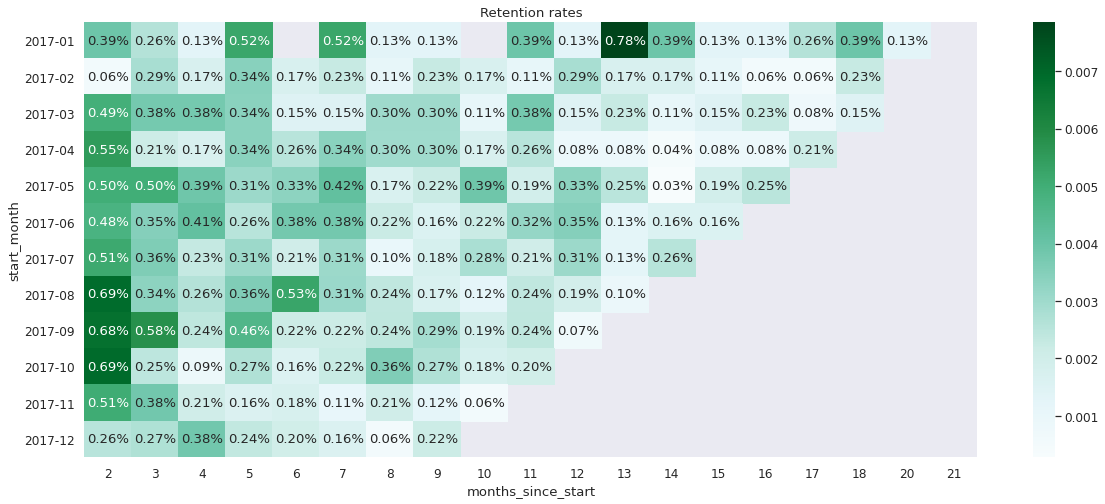

In [55]:
 # визуализируем данные
plt.figure(figsize=(20, 8))
sns.set(font_scale=1.1) 
plt.title('Retention rates')
ax=sns.heatmap(data = retention_table_plot, annot = True, fmt = '.2%',cmap = 'BuGn')

y_dates = retention_table_plot.index.strftime('%Y-%m').sort_values()
ax.set_yticklabels(labels=y_dates)
plt.show()

In [56]:
a= retention_table_plot['3'].sort_values(ascending=False).max().astype('object')*100
b= retention_table_plot['3'].idxmax().strftime('%Y-%m')
print('Задача: В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц')
print ('Ответ: Самый высокий retention на 3 месяц у пользователей, совершивших первую покупку в', b, 'и составляет', a, '%')

Задача: В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц
Ответ: Самый высокий retention на 3 месяц у пользователей, совершивших первую покупку в 2017-09 и составляет 0.581 %


# 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

In [57]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [58]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
order_purchase_date                634
dtype: int64

In [59]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Из данных выше видно, что количество уникальных order_id в таблице orders выше, чем в items. 
Т.е не для всех заказов (order_id) можно будет определить ID товара (product_id) и его цену (price), 
которые нужны для проведения RFM-сегментации пользователей. Сохранять такие заказы нет смысла
По этой причине при объединении таблиц сохраняю только строки с order_id, которые есть в обеих таблицах

In [60]:
# Отбираю нужные данные

items_select=items[['order_id', 'order_item_id', 'product_id', 'price']]
orders_select=orders[['order_id', 'customer_id', 'order_status','order_purchase_date', 'order_approved_at','order_delivered_customer_date']]
customers_select=customers[['customer_id', 'customer_unique_id']]

In [61]:
# Объединяю датасеты для получения нужной информации

rfm_df=items_select.merge(orders_select, on='order_id').merge(customers_select, on='customer_id')
rfm_df

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13,2017-09-13 09:45:35,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26,2017-04-26 11:05:13,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14,2018-01-14 14:48:30,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08,2018-08-08 10:10:18,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04,2017-02-04 14:10:13,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5
...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23,2018-04-25 04:11:01,2018-05-10 22:56:40,0c9aeda10a71f369396d0c04dce13a64
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14,2018-07-17 04:31:48,2018-07-23 20:31:55,0da9fe112eae0c74d3ba1fe16de0988b
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23,2017-10-24 17:14:25,2017-10-28 12:22:22,cd79b407828f02fdbba457111c38e4c4
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14,2017-08-15 00:04:32,2017-08-16 21:59:40,eb803377c9315b564bdedad672039306


In [62]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   price                          112650 non-null  float64       
 4   customer_id                    112650 non-null  object        
 5   order_status                   112650 non-null  object        
 6   order_purchase_date            112650 non-null  datetime64[ns]
 7   order_approved_at              112635 non-null  datetime64[ns]
 8   order_delivered_customer_date  110196 non-null  datetime64[ns]
 9   customer_unique_id             112650 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(5)
memory usage: 

In [63]:
rfm_df.nunique()

order_id                         98666
order_item_id                       21
product_id                       32951
price                             5968
customer_id                      98666
order_status                         7
order_purchase_date                616
order_approved_at                90174
order_delivered_customer_date    95664
customer_unique_id               95420
dtype: int64

In [64]:
# Проверяю дату последнего заказа
rfm_df.sort_values('order_purchase_date').tail(1)

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
37073,54282e97f61c23b78330c15b154c867d,1,b98992ea80b467987a7fbb88e7f2076a,145.0,4b7decb9b58e2569548b8b4c8e20e8d7,shipped,2018-09-03,2018-09-03 17:40:06,NaT,ff22e30958c13ffe219db7d711e8f564


В датасете последний заказ был сделан 2018-09-03. 
Для подсчета Recency возьмем в качестве точки отсчета (now) этот день.
Данный заказ не доставлен. И не ясно будет ли. Для проведения RFM анализа буду отбирать "покупки" 
(в соответствии с критериями озвученными в начале работы). Вследствии чего этот последний заказ не попадет в отбор. 
Но вряд ли это окажет существенное влияние на результат анализа, в особенности при условии, что в заказе всего одна товарная позиция

In [65]:
rfm_df['order_approved_at']=rfm_df['order_approved_at'].fillna(0)
rfm_df['order_delivered_customer_date']=rfm_df['order_delivered_customer_date'].fillna(0) # заполню пропуски

In [66]:
rfm_df=rfm_df.query('order_delivered_customer_date!=0')\
                     .query('order_approved_at!=0')\
                     .query("order_status!='canceled'")

Поскольку большинство покупателей совершило только одну покупку, то детализация по неделям/месяцам будет не информативна.
Поэтому для подсчета Frequency возьмем общее число покупок за весь период, по которому у нас есть данные. 

Для подсчета Monetary посчитаем сумму покупок для каждого уникального покупателя.

In [67]:
now=dt.datetime(2018,9,3)

Посчитаю показатели Recency, Frequency, Monetary 

In [68]:
rfm_table=rfm_df.groupby('customer_unique_id', as_index=False).agg({'order_purchase_date': lambda x: (now - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'price': lambda x: x.sum()})    # Monetary 

In [69]:
rfm_table.rename(columns={'order_purchase_date': 'recency', 
                         'order_id': 'frequency',
                         'price': 'monetary_value'}, inplace=True)


In [70]:
rfm_table['frequency'].unique()# узнаю какие есть варианты у показателя frequency

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15])

In [71]:
rfm_table.groupby('frequency').agg({'customer_unique_id':'count'}) # И какое кол-во каждого из них

,customer_unique_id
frequency,
1,90537
2,2572
3,181
4,28
5,9
6,5
7,3
9,1
15,1


In [72]:
rfm_table['recency'].describe()

count    93337.000000
mean       242.441979
std        152.556084
min          5.000000
25%        119.000000
50%        223.000000
75%        351.000000
max        718.000000
Name: recency, dtype: float64

In [73]:
rfm_table['frequency'].describe()

count    93337.000000
mean         1.033417
std          0.209096
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: frequency, dtype: float64

In [74]:
rfm_table['monetary_value'].describe()

count    93337.000000
mean       141.622063
std        215.713022
min          0.850000
25%         47.650000
50%         89.700000
75%        154.700000
max      13440.000000
Name: monetary_value, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

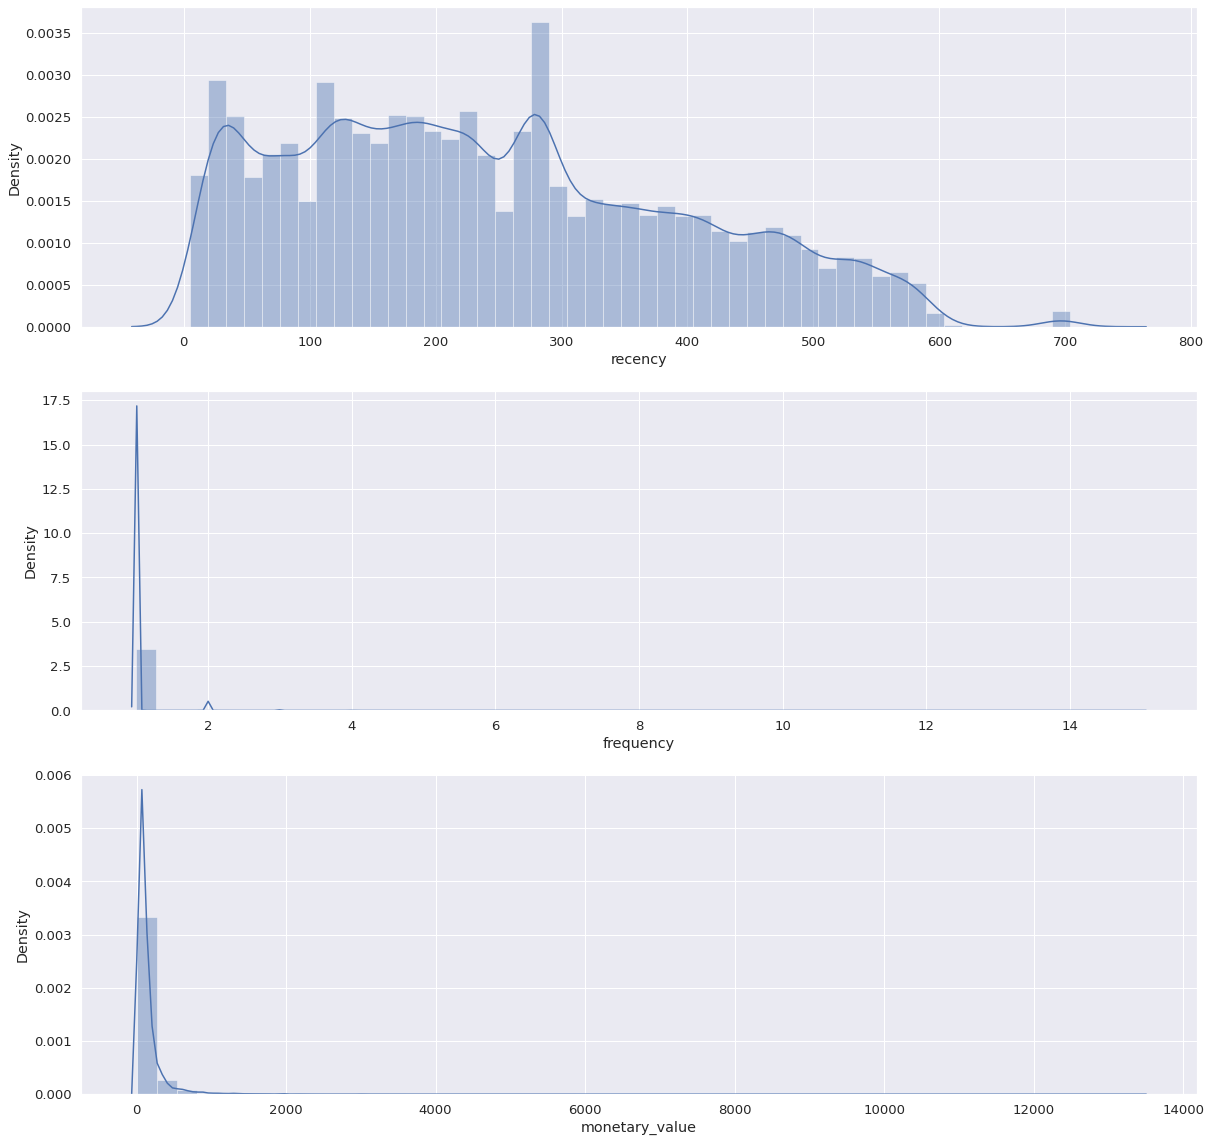

In [75]:
# Построю графики распределения Recency, Frequency, Monetary для нагядности результатов

sns.set(style="whitegrid")
sns.set(font_scale=1.2) 

plt.figure(figsize=(20,20))

plt.subplot(3, 1, 1); sns.distplot(rfm_table['recency'])

plt.subplot(3, 1, 2); sns.distplot(rfm_table['frequency'])

plt.subplot(3, 1, 3); sns.distplot(rfm_table['monetary_value'])

plt.show()

Из графиков распределения давности Recency видно, что основная доля покупок приходится на период до 300 дней.
Можно предположить что в этот период были проведены некоторые мероприятия для привлечения клиентов.
В более долгосрочном периоде количество заказов затухает и сводится практически к нулю на интервале от 600 дней.

А monetary_value говорит что большая часть покупок это покупки с невысокой стоимостью. 
Можно предположить что клиенты делают пробные заказы. 
Это также согласуется с предположением о проведениии мероприятий для привлечения новых покупателей.
При этом есть, хоть и мало, покупателей с большой суммой заказа.
Однако график распределения количества покупок frequency говорит, что основная доля это разовые заказы. 
На данном этапе причина по которой покупатели не стремятся делать повторные покупки не ясна

Наличие заказов с высокой стоимостью, может оказаться также и аномалиями в данных. Попробую посмотреть на данные заказы более детально

In [76]:
items[['product_id', 'price']].sort_values('price', ascending=False)

,product_id,price
3556,489ae2aa008f021502940f251d4cce7f,6735.00
112233,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00
107841,1bdf5e6731585cf01aa8169c7028d6ad,6499.00
74336,a6492cc69376c469ab6f61d8f44de961,4799.00
11249,c3ed642d592594bb648ff4a04cee2747,4690.00
...,...,...
57304,05b515fdc76e888aada3c6d66c201dff,1.20
57300,05b515fdc76e888aada3c6d66c201dff,1.20
48625,8a3254bee785a526d548a81a9bc3c9be,0.85
27652,8a3254bee785a526d548a81a9bc3c9be,0.85


Видно, что существуют товарные позиции, которые стоят как очень дешево (мин цена 0,85), так и, относительно этой стоимости, очень дорого (макс цена 6735)

In [77]:
rfm_table.query('monetary_value>4000').groupby('customer_unique_id', as_index=False)\
            .agg({'monetary_value':'sum'}).sort_values('monetary_value', ascending=False)

,customer_unique_id,monetary_value
0,0a0a92112bd4c708ca5fde585afaa872,13440.00
8,da122df9eeddfedc1dc1f5349a1a690c,7388.00
4,763c8b1c9c68a0229c42c9fc6f662b93,7160.00
9,dc4802a71eae9be1dd28f5d788ceb526,6735.00
2,459bef486812aa25204be022145caa62,6729.00
13,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00
1,4007669dec559734d6f53e029e360987,5934.60
11,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00
3,48e1ac109decbb87765a3eade6854098,4590.00
5,a229eba70ec1c2abef51f04987deb7a5,4400.00


Рассмотрю по отдельности несколько заказов с самой большой суммой.

In [78]:
rfm_df.query("customer_unique_id=='0a0a92112bd4c708ca5fde585afaa872'")

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,1680.0,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29,2017-10-02 15:28:20,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872


In [79]:
rfm_df.query("customer_unique_id=='da122df9eeddfedc1dc1f5349a1a690c'")

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
62453,8ea7aebc18842332aad5f41ca74b334c,1,3ecf69ee1fe21cfd40b30cbea549e563,2589.0,349509b216bd5ec11c5fae929fd13595,delivered,2017-04-01,2017-04-03 13:25:19,2017-04-17 14:36:23,da122df9eeddfedc1dc1f5349a1a690c
74336,a96610ab360d42a2e5335a3998b4718a,1,a6492cc69376c469ab6f61d8f44de961,4799.0,df55c14d1476a9a3467f131269c2477f,delivered,2017-04-01,2017-04-03 13:25:18,2017-04-17 11:04:45,da122df9eeddfedc1dc1f5349a1a690c


In [80]:
rfm_df.query("customer_unique_id=='763c8b1c9c68a0229c42c9fc6f662b93'")

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
50768,736e1922ae60d0d6a89247b851902527,1,19936fa4f614ee0590d3b77ac83fd648,1790.0,ec5b2ba62e574342386871631fafd3fc,delivered,2018-07-15,2018-07-17 04:31:36,2018-07-26 22:03:06,763c8b1c9c68a0229c42c9fc6f662b93
50769,736e1922ae60d0d6a89247b851902527,2,19936fa4f614ee0590d3b77ac83fd648,1790.0,ec5b2ba62e574342386871631fafd3fc,delivered,2018-07-15,2018-07-17 04:31:36,2018-07-26 22:03:06,763c8b1c9c68a0229c42c9fc6f662b93
50770,736e1922ae60d0d6a89247b851902527,3,19936fa4f614ee0590d3b77ac83fd648,1790.0,ec5b2ba62e574342386871631fafd3fc,delivered,2018-07-15,2018-07-17 04:31:36,2018-07-26 22:03:06,763c8b1c9c68a0229c42c9fc6f662b93
50771,736e1922ae60d0d6a89247b851902527,4,19936fa4f614ee0590d3b77ac83fd648,1790.0,ec5b2ba62e574342386871631fafd3fc,delivered,2018-07-15,2018-07-17 04:31:36,2018-07-26 22:03:06,763c8b1c9c68a0229c42c9fc6f662b93


In [81]:
rfm_df.query("customer_unique_id=='dc4802a71eae9be1dd28f5d788ceb526'")

,order_id,order_item_id,product_id,price,customer_id,order_status,order_purchase_date,order_approved_at,order_delivered_customer_date,customer_unique_id
3556,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,6735.0,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12,2017-02-12 20:45:12,2017-03-03 14:23:18,dc4802a71eae9be1dd28f5d788ceb526


Из данных выше видно, что есть заказы в которых высокая сумма заказа обусловлена наличием повторяющихся товарных позиций. Возможно предположить что здесь данные задублировались, но есть и такие, где товары дорогостоящие, но не повторяются в заказе. Т.о у меня нет достаточной информации, на основании которой можно было бы отбросить эти заказы с экстремальными суммами, поэтому для дальнейшего анализа оставляю их, принимая как корректные

In [82]:
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.6, 0.75, 0.9])
quantiles 

,recency,frequency,monetary_value
0.25,119.0,1.0,47.65
0.50,223.0,1.0,89.70
0.60,273.0,1.0,109.90
0.75,351.0,1.0,154.70
0.90,470.0,1.0,279.99


Как видно, более 90 % покупателей сделали всего 1 покупку. 
Категоризация в части frequency по квартилям будет не информативна, нужна особым порядком

Рассмотрю более подробно recency для понимания как распределяются покупки сделанные в периоде примерно до года (75% квартиль). 
Это поможет выбрать интервалы для категоризации пользователей  

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


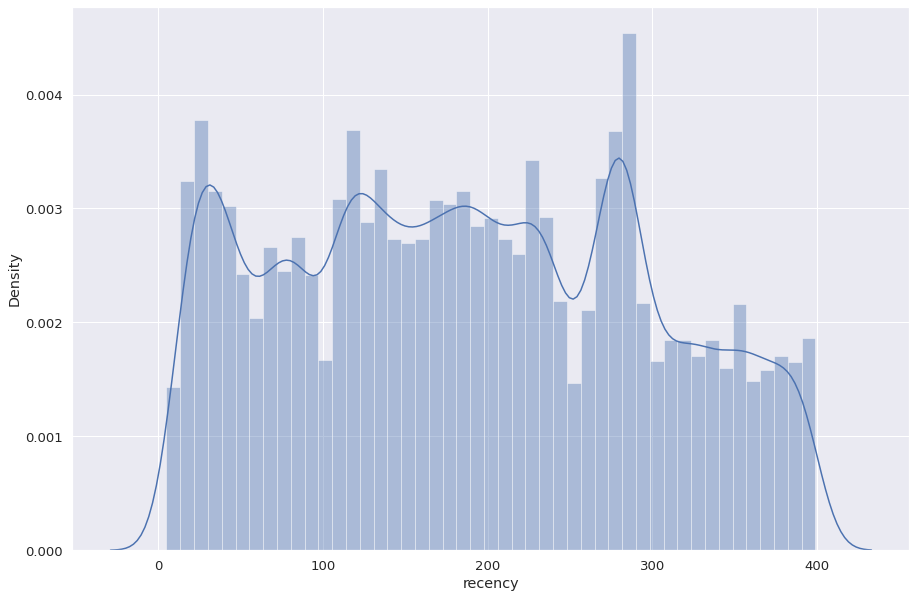

In [83]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2) 
plt.figure(figsize=(15,10))
sns.distplot(rfm_table[rfm_table['recency']<400]['recency'])

Рассмотрю более подробно monetary_value для понимания как распределяются суммы небольших покупок. 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


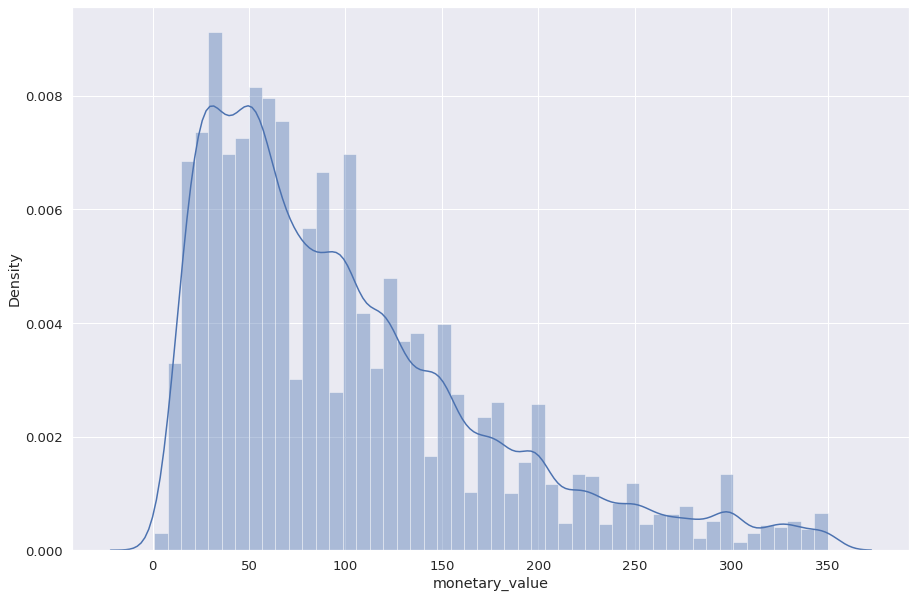

In [84]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2) 
plt.figure(figsize=(15,10))
sns.distplot(rfm_table[rfm_table['monetary_value']<350]['monetary_value'])

Объявим границы для сегментов.

RECENCY. 
Первая группа в рейтинге будет -  более года.
Вторая группа будет 90-365 дней, потому что в этот период еще есть шанс привлечь клиента к повторной покупке. 
И третий период (рейтинг)- с покупками "до 90 дней", самые "теплые" покупатели.  

Наиболее давним покупкам присаивается меньшее значение рейтинга

FREQUENCY. Поскольку основная масса покупателей совершила одну покупку, то выделю их в отдельную категорию. 
Также из предыдущего анализа известно, что покупателей с количеством покупок более 10 всего один.
Выделять его в отдельную категорию не вижу особого смысла
Поэтому разделю на следующие категории:
1: одна покупка, 2: до 5 покупок, 3: более 5 покупок

Наименьшему значению frequency присваивается меньшее значение рейтинга

MONETARY. На основании детализированных графиков выше и с учетом того, что 60 % перцентиль показывает сумму 109, а 75-й -351,
разделяю клиентов по сумме покупок на следующие группы:
1: 0-100, 2:101-300, 3:301-и далее 

Покупкам с наименьшей суммой присваивается меньшее значение рейтинга



In [85]:
groups = {'recency': {1: 90, 2: 365}, 'monetary_value': {1: 100, 2: 300}, 'frequency': {1: 1, 2: 5}}

In [86]:
# объявим функцию для присвоения рейтинга клиентам соответственно каждой группе
def r_score(x):
    if x <= groups['recency'][1]:
        return 3
    elif x <= groups['recency'][2]:
        return 2
    else:
        return 1

In [87]:
def m_score(x):
    if x <= groups['monetary_value'][1]:
        return 1
    elif x <= groups['monetary_value'][2]:
        return 2
    else:
        return 3

In [88]:
def f_score(x):
    if x <= groups['frequency'][1]:
        return 1
    elif x <= groups['frequency'][2]:
        return 2
    else:
        return 3

In [89]:
rfm_table['recency_score'] = rfm_table['recency'].apply(lambda x: r_score(x))
rfm_table['frequency_score'] = rfm_table['frequency'].apply(lambda x: f_score(x))
rfm_table['monetary_score'] = rfm_table['monetary_value'].apply(lambda x: m_score(x))

In [90]:
# Итоговый, сводный рейтинг каждого клиента
rfm_table['rfm_score'] = rfm_table.recency_score.astype(str)+ rfm_table.frequency_score.astype(str) + rfm_table.monetary_score.astype(str)
rfm_table.sort_values('rfm_score', ascending=False).head(22)

,customer_unique_id,recency,frequency,monetary_value,recency_score,frequency_score,monetary_score,rfm_score
36700,6469f99c1f9dfae7733b25662e7f1782,67,7,664.20,3,3,3,333
51421,8d50f5eadf50201ccdcedfb9e2ac8455,14,15,714.63,3,3,3,333
80520,dc813062e0fc23409cd255f7f53c7074,11,6,687.76,3,3,3,333
2054,059e7585d8fcd2430a33375bdbcbb990,15,2,434.69,3,2,3,323
73113,c8460e4251689ba205045f3ea17884a1,26,4,4080.00,3,2,3,323
1173,032b3a42598667caf2e099999b9dc1b9,41,2,387.70,3,2,3,323
24178,423d40b193638955a782839886648464,27,2,917.90,3,2,3,323
10212,1bcbeccb2851888f299cf9a5dba8553d,29,2,316.99,3,2,3,323
45679,7d0983269f825d3112e5a64364b1258a,49,2,595.90,3,2,3,323
21002,397b44d5bb99eabf54ea9c2b41ebb905,78,4,1650.00,3,2,3,323


In [91]:
# Посчитаю количество уникальных сегментов

rfm_table['rfm_score'].nunique()

21

Итого мы получили 21 уникальную группу покупателей.

In [92]:
rfm_groups=rfm_table.groupby('rfm_score',as_index=False)\
                    .agg({'customer_unique_id':'count'})\
                    .sort_values('customer_unique_id', ascending=False)\
                    .rename(columns={'customer_unique_id':'customers_count'})
rfm_groups #считаю количество клиентов вкаждом сегменте

,rfm_score,customers_count
7,211,30579
8,212,17800
0,111,12539
14,311,9887
1,112,6561
15,312,5850
9,213,4252
2,113,1720
16,313,1349
11,222,913


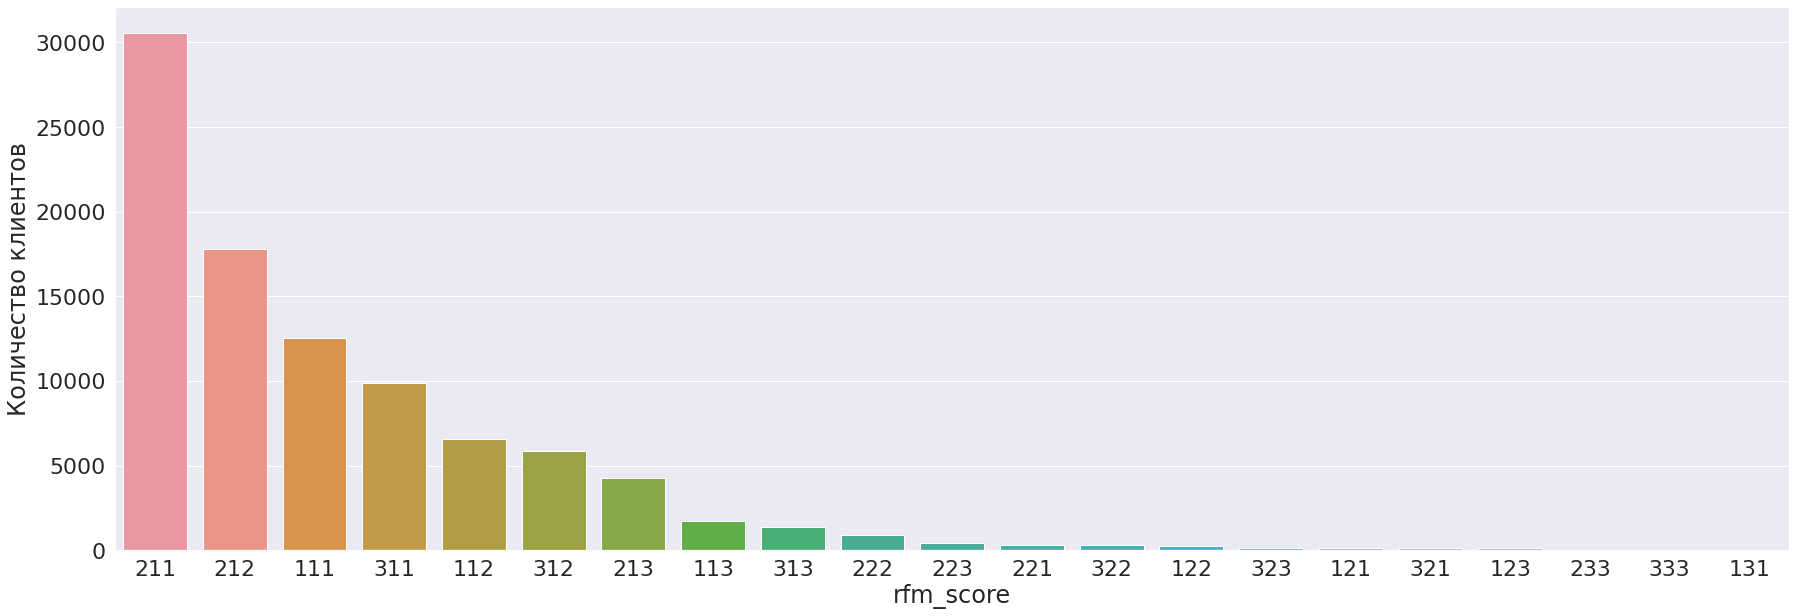

In [93]:
# Визуализирую полученные результаты

plt.figure(figsize=(30,10))
sns.set(font_scale=2) 
sns.barplot(data=rfm_groups,x='rfm_score', y='customers_count')
plt.xlabel('rfm_score')
plt.ylabel('Количество клиентов')
plt.show()


In [94]:
data=[['1', 'более 365','1', '0-100'],['2', '90-365','1-5', '101-300'], ['3', 'до 90','более 5', 'более 300']]

Границы сегментов:

In [95]:
pd.DataFrame(data, columns=['Rate','Recency', 'Frequency', 'Monetary'])

,Rate,Recency,Frequency,Monetary
0,1,более 365,1,0-100
1,2,90-365,1-5,101-300
2,3,до 90,более 5,более 300


Покупателей с рейтингом 111 можно отбросить.
Как видно, основные клиенты - это покупатели '211' -сделавшие заказ в периоде 90-365 дней, всего один раз на сумму до 100.
Также интерес могут представлять категории '311' -недавние покупатели (до 90 дней) с одним заказом на сумму до 100,
'212' -покупатели  в периоде 90-365 дней, один заказ, и средней суммой покупок (100-300)  
и '312' - недавно купившие, один раз на среднюю сумму чека
Именно на эти группы имеет смысл сделать акцент и привлекать к повторным покупкам
Также достаточно важно удержать то небольшое количество клиентов с рейтингами '213', '313', '223' и '323'